In [9]:
import numpy as np
import datetime
from ga_functions import *
import matplotlib.pyplot as plt

In [18]:
params       = np.load('CL_data/parameter_test8.npy')
# params = [[H0_1, ombh2_1, omch2_1], [H0_2, ombh2_2, omch2_2], ... ]
cls_unlensed = np.load('CL_data/unlensed_CL8.npy')
cls_lensed   = np.load('CL_data/lensed_CL8.npy')

n_data = len(params)

n_train_data = int(0.8*n_data)
n_val_data   = n_data - n_train_data

ells_factor = [ell*(ell+1) for ell in range(2,5000)]

# constructing data structure for use in ga algorithm

tot_data_points = []
for i in range(n_data):
    dat = {}
    dat["H0"] = params[i, 0]
    dat["ombh2"] = params[i, 1]
    dat["omch2"] = params[i, 2]
    dat["tau"] = 0.06
    dat["As"] = 3
    dat["cls_lensed"] = cls_lensed[i]*2*np.pi
    dat["cls_unlensed"] = cls_unlensed[i]*2*np.pi
    tot_data_points.append(dat)

train_data_points = tot_data_points[:n_train_data]
val_data_points = tot_data_points[n_train_data:]


print("Parameter Ranges:\n")

print(round(np.min(params[:, 0]), 5), " <   H0  < ",round(np.max(params[:, 0]), 5))

print(round(np.min(params[:, 1]), 5), "  < ombh2 < ",round(np.max(params[:, 1]), 5))

print(round(np.min(params[:, 2]), 5), "   < omch2 < ",round(np.max(params[:, 2]), 5))

Parameter Ranges:

45.09358  <   H0  <  94.48145
0.01501   < ombh2 <  0.034
0.0304    < omch2 <  0.17974


In [5]:
# GA SETTINGS

config = {}

n_genes = 12 + 2 + 7 + 1
config["n_genes"] = n_genes
# n_genes is the number of constants that GA will be tuning. this is hard-coded here and in candFunction.tot_genes
# (hard-coded for now...)

# !!n_genes must be the same value as candFunction.tot_genes!!



n_pop = 50 # number of functions in the GA population
config["population"]  = n_pop
# I have not played around with how this number affects convergence/stability


config["generations"] = 200 # GA generations, 100 is usually OK... 200 to be more thorough

config["num_mutations"] = 250 # number of mutations per generation of GA
config["tournament_size"] = int(0.1*n_pop) # tournament sub-group selection... I set it at 10% of n_pop
config["batch_size"] = 50 # num of data points to use for fitness calculation

# [p_mutate_single_gene, p_mutate_multiple_genes, p_new_expression, p_do_nothing]
# probabilities associated with the above mutations^
config["mutation_probs"] = [0.68, 0.17, .05, 0.10] 
config["p_crossbreed"] = 0.01 # probability of crossbreeding
# I have not played around with how these numbers affect convergence/stability


wayne_plus_polynomial_init = [0.0396, -0.248, 13.6, 0.638, 1480, -0.0606, 10.2, 0.553, 1.03, 0.0335, -0.0473, -0.0639, 1, 0.1, 1, 0.1, 1, 0.1, 0.1, 1.2, 1200, -3.3]
config["init_genes"] = wayne_plus_polynomial_init

# initial values for GA... I used waynes values for the damping formula... 
# plus my own crude guess for alpha in the lensing fit... plus guesses for l_d and m and, -3.3 offset

config["ranges"] = np.array([[np.abs(initial_gene_vals[i])*0.5, np.abs(initial_gene_vals[i])*1.5] for i in range(n_genes)])
# I set ranges as a neighborhood around the initial GA values...
# (ranges are only used when new_expression mutation is performed... i.e. the old function is replaced with an
# entirely new function using genes randomly picked from the ranges above)

config["do_dynamic_ranges"] = True
# dynamic ranges greatly improve convergence and stability... I recommend leave set to True

ga = geneticAlgorithm(config, train_data_points)

In [26]:
RUN_GA = False
# TRUE to run new GA
# FALSE to evaluate function with your own set params

if RUN_GA:
    ga.run_algorithm()
    best = ga.best_fit_func # best_fit_func is the best GA produced result
else:
    best = candFunction()
    best.set_genes(np.array([4.26398606e-02, -9.12242046e-02,  8.78158071e+00,  4.79656278e-01, -5.29962844e+02,  2.83493944e-01, -9.54339785e+01,  4.78245558e-01, 1.30144792e+00,  3.72507690e-02,  4.18511061e-02,  1.88684710e-01, -1.24842720e-01,  4.20895697e-02,  1.02981507e-02,  3.01179665e-01, 1.78273692e-01, -3.56854405e-03,  9.83321082e-02,  1.09731805e+00, 2.23579774e+03, -3.16097530e+00]))

print("\nLearned:\n")
best.genes


Learned:



array([ 4.26398606e-02, -9.12242046e-02,  8.78158071e+00,  4.79656278e-01,
       -5.29962844e+02,  2.83493944e-01, -9.54339785e+01,  4.78245558e-01,
        1.30144792e+00,  3.72507690e-02,  4.18511061e-02,  1.88684710e-01,
       -1.24842720e-01,  4.20895697e-02,  1.02981507e-02,  3.01179665e-01,
        1.78273692e-01, -3.56854405e-03,  9.83321082e-02,  1.09731805e+00,
        2.23579774e+03, -3.16097530e+00])

On training data...


No handles with labels found to put in legend.


Text(0, 0.5, '$C_\\ell^{TT}$')

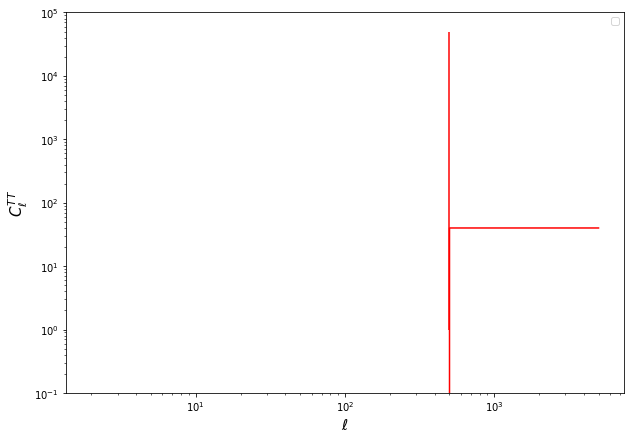

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
ells = np.arange(2,5000)

params_causing_spike = []

print("On training data...")
for k in range(len(train_data_points)):
    dat = train_data_points[k]
    par = [dat["ombh2"], dat["omch2"], dat["H0"], 0.06, 1, 3]
    
    unlensed_undamped = dat["cls_lensed"]/best.compute(par)
    
    if unlensed_undamped[-1] > 80:
        params_causing_spike.append([par[0], par[1], par[2]])
    
horizontal_loss = np.array(4998*[40])
horizontal_loss[0:500] = 0
ax.loglog(ells, horizontal_loss, color="r") # red line to show loss function value

ax.vlines(500, 1, 50000, color = "r") # cutoff point... for l > cutoff the loss is calculated against the fixed value above, 50
ax.set_xlabel("$\ell$", fontsize=15)
ax.set_ylabel("", fontsize=15)
#ax.set_xlim(0,4500)
ax.set_ylim(10e-2,10e4)
ax.legend()
ax.set_ylabel("$C_\ell^{TT}$", fontsize=15)

on val data...


Text(0, 0.5, '$C_\\ell^{TT}$')

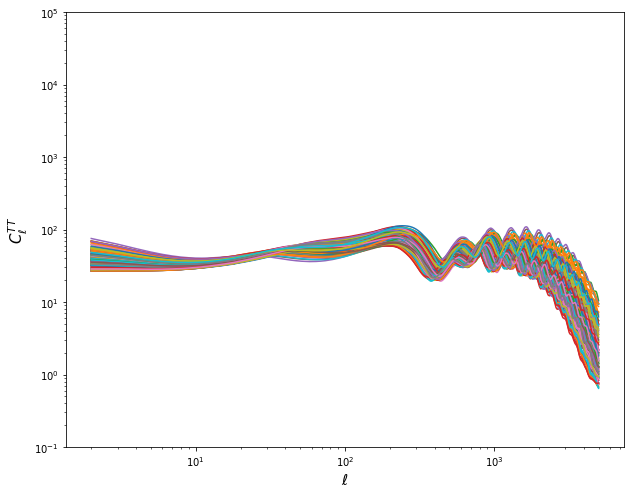

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

print("On val data...")
for k in range(n_val_data):
    dat = val_data_points[k]
    par = [dat["ombh2"], dat["omch2"], dat["H0"], 0.06, 1, 3]
    unlensed_undamped = dat["cls_lensed"]/best.compute(par)
    
    if unlensed_undamped[-1] > 80:
        params_causing_spike.append([par[0], par[1], par[2]])
        
    ax.loglog(ells, unlensed_undamped)
    
    #ax.legend()
    
horizontal_loss = np.array(4998*[40])
horizontal_loss[0:500] = 0
ax.loglog(ells, horizontal_loss, color="r") # red line to show loss function value

ax.vlines(500, 1, 50000, color = "r") # cutoff point... for l > cutoff the loss is calculated against the fixed value above, 50
ax.set_xlabel("$\ell$", fontsize=15)
ax.set_ylabel("", fontsize=15)
#ax.set_xlim(1000, 5000)
ax.set_ylim(10e-2,10e4)
ax.set_ylabel("$C_\ell^{TT}$", fontsize=15)

on all data...


Text(0, 0.5, '$C_\\ell^{TT}$')

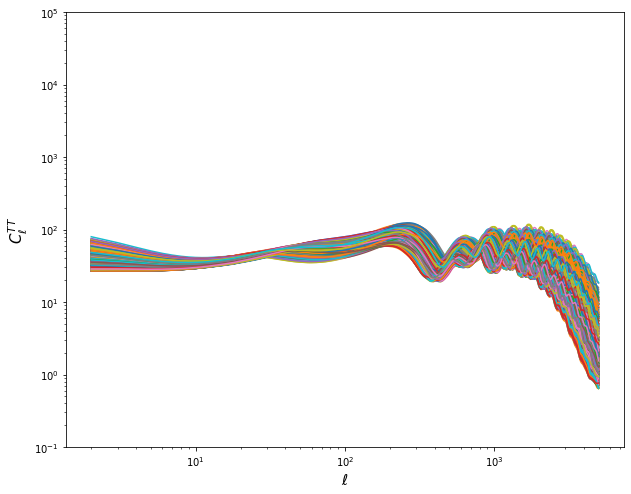

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
print("on all data...")

for k in range(n_data):
    dat = tot_data_points[k]
    par = [dat["ombh2"], dat["omch2"], dat["H0"], 0.06, 1, 3]
    
    unlensed_undamped = dat["cls_lensed"]/best.compute(par)
        
    ax.loglog(ells, unlensed_undamped)
    
    #ax.legend()
    
horizontal_loss = np.array(4998*[50])
horizontal_loss[0:500] = 0
ax.loglog(ells, horizontal_loss, color="r") # red line to show loss function value

ax.vlines(500, 1, 50000, color = "r") # cutoff point... for l > cutoff the loss is calculated against the fixed value above, 50
ax.set_xlabel("$\ell$", fontsize=15)
ax.set_ylabel("", fontsize=15)
#ax.set_xlim(1000, 5000)
ax.set_ylim(10e-2,10e4)
ax.set_ylabel("$C_\ell^{TT}$", fontsize=15)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

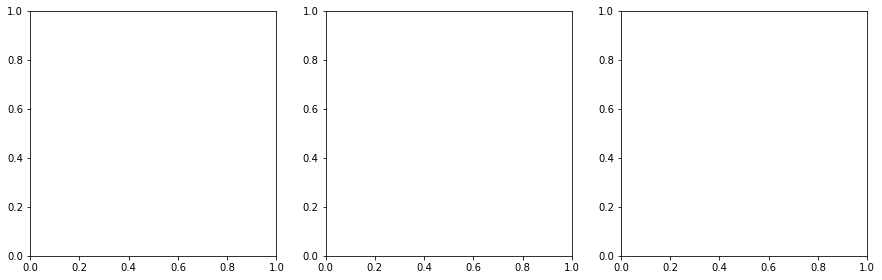

In [11]:
params_causing_spike = np.array(params_causing_spike)
fig, ax = plt.subplots(1,3, figsize=(15,4.5))
ax[0].hist(params_causing_spike[:, 0], bins = 10)
ax[0].set_title("bad ombh2")
ax[0].set_xlim(0.009, 0.038)
ax[1].hist(params_causing_spike[:, 1], bins = 10)
ax[1].set_title("bad omch2")
ax[1].set_xlim(0.03, 0.23)
ax[2].hist(params_causing_spike[:, 2], bins = 10)
ax[2].set_title("bad H0")
ax[2].set_xlim(25, 114)

In [ ]:
# "...2.npy" best 

# [0.05211832, 0.02719349, 10.08927592, 0.38897415, -10287.49222006, -0.08286088, -10.42422681, -0.09849962, 0.73647705, -0.02764215, -0.07000514, -0.01150559, -1.80290493, 1.50037718, 1.05683584, -0.24742542, 0.02922115, 0.05925169, 0.0332392, 0.01653288, 1049.56543224, -3.3]

In [ ]:
# "...3.npy" best 

# [-5.75816203e-02, -3.17970256e-01, -6.02770259e+00,  4.00210319e-01, -2.17098139e+02,  3.37289754e+00, -2.28601560e+00,  2.08355231e+00, 1.05561624e+00,  4.48874499e-02,  2.13391133e-03,  4.09357930e-03, -6.38047815e-01, -9.44960928e-02, -2.16708402e+00,  1.45938497e-02, 6.02172094e-02,  2.84449106e-01, -4.21501782e-01,  1.12139959e+00, 1.20034268e+03, -6.03702262e-01]

In [ ]:
# "...4A.npy" best

# intermediate -> [3.61785862e-02,  1.40595229e-01,  9.92631239e+00,  1.98244079e-01, -1.21792613e+03,  1.26343428e+00,  3.67335975e+01, -3.67166937e-02, 1.40889023e+00,  3.90673197e-02,  6.83972616e-02,  9.68018085e-02, -7.23442912e-01,  1.08517471e-02, -1.55489199e-02, -3.68742850e-02, 1.88500655e+00,  1.73885472e+00,  8.56556917e-04,  3.31984196e-01, 1.45729004e+03, -5.48539652e-01]
#              -> [2.50378189e-02,  1.02345451e-01,  1.23524196e+01,  1.85593808e-01, -6.69266604e+03,  6.72035761e-01,  2.18988278e+01,  6.44701077e-03,1.39237078e+00,  3.30189475e-02,  7.63344828e-02,  6.07923932e-02, -1.14464005e+00,  7.39816474e-03,  2.20034754e-03,  1.09187112e-03, -1.64782898e-01,  1.33545277e+01,  1.56685423e-03,  3.60055069e-01, 2.71378014e+02,  1.77095917e-01]

In [ ]:
# "...5.npy" best
# [ 3.29426020e-02,  1.55698283e-01,  1.21654770e+01,  2.12047641e-01, -8.65541976e+02,  1.86124179e+01,  4.78141374e+02, -6.18975898e-03, 1.68963127e+00,  6.52848530e-02,  9.53053397e-02,  5.84055564e-02, 9.50965101e-01,  4.52455994e-02,  3.28203459e-03, -1.20510345e-01, -1.69927875e-02,  4.84270771e+01,  4.74227750e-05, -5.21796697e-01, 1.27670653e+01, -7.72004410e-01]

In [ ]:
# [4.05464968e-02, -1.42459126e-01,  1.05443521e+01,  5.37464927e-01, -7.94815314e+03,  6.90277591e-02, -1.50544775e+01,  7.13510010e-03, 8.49317333e-01, -4.68639890e-02, -5.99547281e-02,  2.03338425e-01, 4.70796608e-01,  1.33076627e-01,  7.01355164e-01, -2.61675030e-01, 1.62719606e-01,  1.49476060e-03,  4.20013631e-02,  2.84053396e-01, 2.13239671e+03, -3.54162637e+00]